In [70]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Dropout, Input, Flatten, LSTM, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x, y): return top_k_categorical_accuracy(x, y, 3)

tf.__version__

'1.14.0'

In [71]:
# Constants
BATCH_SIZE = 256
EPOCHS = 20
LABELS = [["SFGPUCA-----", "Friendly Armored"], ["SFGPUCF-----", "Friendly Artillery"], ["SFGPUCI-----", "Friendly Infantry"], 
          ["SFGPUCR-----", "Friendly Reconnaisance"], ["SHGPUCA-----", "Hostile Armored"], ["SHGPUCF-----", "Hostile Artillery"], 
          ["SHGPUCI-----", "Hostile Infantry"], ["SHGPUCR-----", "Hostile Reconnaisance"]]

for label in LABELS:
    print(label[1])

Friendly Armored
Friendly Artillery
Friendly Infantry
Friendly Reconnaisance
Hostile Armored
Hostile Artillery
Hostile Infantry
Hostile Reconnaisance


In [72]:
# Data extraction and visulization
df = pd.read_csv("symbolData/SymbolData.csv")
df.head()

,x,y,t,pixels,label,id
0,"684,658,632,616,585,548,514,483,460,446,438,43...","377,338,299,277,233,183,134,88,48,24,10,2,0,2,...","42,80,94,103,119,136,154,169,187,202,221,237,2...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Armored,SHGPUCA-----
1,"696,695,693,683,671,646,606,564,522,481,440,40...","400,400,400,396,384,356,310,253,192,140,93,58,...","14,22,37,55,71,88,105,120,138,155,170,188,204,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Armored,SHGPUCA-----
2,"136,130,129,124,121,118,110,106,98,94,85,82,79...","9,14,15,19,22,23,29,32,37,40,45,48,51,60,62,64...","45,60,72,74,82,90,98,106,114,122,130,138,147,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Infantry,SHGPUCI-----
3,"978,949,902,836,717,634,568,507,462,438,429,42...","592,562,515,451,332,233,155,82,35,9,1,0,0,3,10...","25,43,58,75,91,108,126,142,158,175,191,208,226...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Armored,SHGPUCA-----
4,"157,155,154,151,147,145,139,136,132,129,127,12...","1,2,3,3,6,8,10,11,16,18,18,21,22,25,27,28,31,3...","6,23,31,39,47,56,64,72,80,89,96,104,112,120,12...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",Hostile Reconnaisance,SHGPUCR-----


In [73]:
df['x'] = np.array(df.x.apply(lambda x: x.split(',')))
df['y'] = np.array(df.y.apply(lambda x: x.split(',')))
df['t'] = np.array(df.t.apply(lambda x: x.split(',')))
df['pixels'] = df.pixels.apply(lambda x: x.split(','))
df['label'] = df.label.apply(lambda x: x.split(','))

df.head()

,x,y,t,pixels,label,id
0,"[684, 658, 632, 616, 585, 548, 514, 483, 460, ...","[377, 338, 299, 277, 233, 183, 134, 88, 48, 24...","[42, 80, 94, 103, 119, 136, 154, 169, 187, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Armored],SHGPUCA-----
1,"[696, 695, 693, 683, 671, 646, 606, 564, 522, ...","[400, 400, 400, 396, 384, 356, 310, 253, 192, ...","[14, 22, 37, 55, 71, 88, 105, 120, 138, 155, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Armored],SHGPUCA-----
2,"[136, 130, 129, 124, 121, 118, 110, 106, 98, 9...","[9, 14, 15, 19, 22, 23, 29, 32, 37, 40, 45, 48...","[45, 60, 72, 74, 82, 90, 98, 106, 114, 122, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Infantry],SHGPUCI-----
3,"[978, 949, 902, 836, 717, 634, 568, 507, 462, ...","[592, 562, 515, 451, 332, 233, 155, 82, 35, 9,...","[25, 43, 58, 75, 91, 108, 126, 142, 158, 175, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Armored],SHGPUCA-----
4,"[157, 155, 154, 151, 147, 145, 139, 136, 132, ...","[1, 2, 3, 3, 6, 8, 10, 11, 16, 18, 18, 21, 22,...","[6, 23, 31, 39, 47, 56, 64, 72, 80, 89, 96, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Hostile Reconnaisance],SHGPUCR-----


In [74]:
df['target'] = df['id']

# Converting labels into uniqe numbers
for i, label_id in enumerate(df['id']):
    df['target'][i] = LABELS.index([label_id, *df['label'][i]])

half_len_pixel_array = int(len(df['pixels'][0])**(1/2))
    
# Normalizing pixel data
for i, array in enumerate(df['pixels']):
    for j, val in enumerate(array):
        df['pixels'][i][j] = int(val) / 255
    df['pixels'][i] = np.reshape(df['pixels'][i], (-1, half_len_pixel_array))
    
print(df['pixels'][0].shape)

# Converting to ints
for i, array in enumerate(df['x']):
    for j, val in enumerate(array):
        try:
            df['x'][i][j] = int(val)
        except:
            print(i)
            print(array)

for i, array in enumerate(df['y']):
    for j, val in enumerate(array):
        try:
            df['y'][i][j] = int(val)
        except:
            print(i)
            print(array)

for i, array in enumerate(df['t']):
    for j, val in enumerate(array):
        try:
            df['t'][i][j] = int(val)
        except:
            print(i)
            print(array)
        
# Normalizing x and y
for i, array in enumerate(df['x']):
    for j, val in enumerate(array):
        df['x'][i][j] = df['x'][i][j] / max(df['x'][i])

for i, array in enumerate(df['y']):
    for j, val in enumerate(array):
        df['y'][i][j] = df['y'][i][j] / max(df['y'][i])

        
df['strokes'] = df['label']


# devide into strokes
MAX_STROKES = 0
strokes_num = 0
for i, array in enumerate(df['t']):
    new_x = []
    new_y = []
    new_t = []
    start_index_holder = 0
    for j, value in enumerate(array):
        if j != 0 and value < df['t'][i][j-1]:
            new_x.append(df['x'][i][start_index_holder:j])
            new_y.append(df['y'][i][start_index_holder:j])
            new_t.append(df['t'][i][start_index_holder:j])
            
            start_index_holder = j
    
    new_x.append(df['x'][i][start_index_holder:])
    new_y.append(df['y'][i][start_index_holder:])
    new_t.append(df['t'][i][start_index_holder:])
    
    strokes_num = len(new_x)
    if strokes_num > MAX_STROKES:
        MAX_STROKES = strokes_num
    
    df['x'][i] = np.array(new_x)
    df['y'][i] = np.array(new_y)
    df['t'][i] = np.array(new_t)
    df['strokes'][i] = strokes_num

    
# Normalizing t
for i, array in enumerate(df['t']):
    for j, subarray in enumerate(array):
        for k, val in enumerate(subarray):
            df['t'][i][j][k] = (df['t'][i][j][k] - min(df['t'][i][j])) / max(df['t'][i][j])

df.head()

(64, 64)


,x,y,t,pixels,label,id,target,strokes
0,"[[1.0, 0.9733727810650887, 0.9349112426035503,...","[[0.5026666666666667, 0.45066666666666666, 0.3...","[[0.0, 0.04092071611253197, 0.0480818414322250...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4,2
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.96274217585693, 0...","[[0.4756242568370987, 0.4756242568370987, 0.47...","[[0.0, 0.010124252185918085, 0.017027151403589...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4,2
2,"[[0.45484949832775917, 0.43478260869565216, 0....","[[0.03272727272727273, 0.05090909090909091, 0....","[[0.0, 0.02030456852791878, 0.0243654822335025...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Infantry],SHGPUCI-----,6,3
3,"[[1.0, 1.0, 0.9575371549893843, 0.887473460721...","[[0.6084275436793423, 0.5775950668036999, 0.52...","[[0.0, 0.020863658418243572, 0.028141678796700...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4,2
4,"[[0.6061776061776062, 0.5984555984555985, 0.59...","[[0.004, 0.008, 0.012, 0.012, 0.024, 0.032, 0....","[[0.0, 0.008409506398537478, 0.011334552102376...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Reconnaisance],SHGPUCR-----,7,2


In [75]:
print(len(df['target']))
df.dropna(inplace=True)
print(len(df['target']))

df.head()

137
137


,x,y,t,pixels,label,id,target,strokes
0,"[[1.0, 0.9733727810650887, 0.9349112426035503,...","[[0.5026666666666667, 0.45066666666666666, 0.3...","[[0.0, 0.04092071611253197, 0.0480818414322250...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4,2
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.96274217585693, 0...","[[0.4756242568370987, 0.4756242568370987, 0.47...","[[0.0, 0.010124252185918085, 0.017027151403589...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4,2
2,"[[0.45484949832775917, 0.43478260869565216, 0....","[[0.03272727272727273, 0.05090909090909091, 0....","[[0.0, 0.02030456852791878, 0.0243654822335025...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Infantry],SHGPUCI-----,6,3
3,"[[1.0, 1.0, 0.9575371549893843, 0.887473460721...","[[0.6084275436793423, 0.5775950668036999, 0.52...","[[0.0, 0.020863658418243572, 0.028141678796700...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Armored],SHGPUCA-----,4,2
4,"[[0.6061776061776062, 0.5984555984555985, 0.59...","[[0.004, 0.008, 0.012, 0.012, 0.024, 0.032, 0....","[[0.0, 0.008409506398537478, 0.011334552102376...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[Hostile Reconnaisance],SHGPUCR-----,7,2


In [76]:
TRAIN_TEST_SPLIT = len(df['pixels']) - 10

rnn_train_X, rnn_train_y = np.array([array for array in df['pixels'][:TRAIN_TEST_SPLIT]]), np.array([array for array in df['target'][:TRAIN_TEST_SPLIT]])
rnn_test_X, rnn_test_y = np.array([array for array in df['pixels'][TRAIN_TEST_SPLIT:]]), np.array([array for array in df['target'][TRAIN_TEST_SPLIT:]])

for i, array in enumerate(df['pixels']):
    df['pixels'][i] = np.reshape(array, df['pixels'][i].shape + (1,))

cnn_train_X, cnn_train_y = np.array([array for array in df['pixels'][:TRAIN_TEST_SPLIT]]), np.array([array for array in df['target'][:TRAIN_TEST_SPLIT]])
cnn_test_X, cnn_test_y = np.array([array for array in df['pixels'][TRAIN_TEST_SPLIT:]]), np.array([array for array in df['target'][TRAIN_TEST_SPLIT:]])

print(cnn_train_X.shape)
print(cnn_test_X.shape)

(127, 64, 64, 1)
(10, 64, 64, 1)


In [77]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(half_len_pixel_array, half_len_pixel_array, 1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(Flatten())

cnn_input = Input(shape=(half_len_pixel_array, half_len_pixel_array, 1))
cnn_tensor = cnn_model(cnn_input)

In [78]:
rnn_model = Sequential()
rnn_model.add(LSTM(128, input_shape=(rnn_train_X.shape[1:]), activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.2))

rnn_model.add(LSTM(128, activation='relu'))
rnn_model.add(Dropout(0.2))

rnn_input = Input(shape=(rnn_train_X.shape[1:]))
rnn_tensor = rnn_model(rnn_input)

In [79]:
merged = tf.keras.layers.concatenate([cnn_tensor, rnn_tensor])

output = Dense(len(LABELS), activation='softmax')(merged)

model = Model(inputs=[cnn_input, rnn_input], outputs=output)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

"""
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
"""

"\nfrom tensorflow.keras.utils import plot_model\nplot_model(model, to_file='model.png')\n"

In [80]:
# Training
history = model.fit([cnn_train_X, rnn_train_X], rnn_train_y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_split=0.1)

Train on 114 samples, validate on 13 samples
Epoch 1/20
114/114 [==============================] - 1s 12ms/sample - loss: 2.0970 - acc: 0.0789 - val_loss: 1.9585 - val_acc: 0.0769
Epoch 2/20
114/114 [==============================] - 1s 5ms/sample - loss: 1.9709 - acc: 0.2105 - val_loss: 1.8265 - val_acc: 0.1538
Epoch 3/20
114/114 [==============================] - 0s 4ms/sample - loss: 1.8334 - acc: 0.3596 - val_loss: 1.6861 - val_acc: 0.2308
Epoch 4/20
114/114 [==============================] - 0s 4ms/sample - loss: 1.6695 - acc: 0.4561 - val_loss: 1.5449 - val_acc: 0.3846
Epoch 5/20
114/114 [==============================] - 0s 4ms/sample - loss: 1.4782 - acc: 0.5965 - val_loss: 1.3471 - val_acc: 0.4615
Epoch 6/20
114/114 [==============================] - 0s 4ms/sample - loss: 1.2294 - acc: 0.7456 - val_loss: 1.0899 - val_acc: 0.6923
Epoch 7/20
114/114 [==============================] - 0s 4ms/sample - loss: 0.9461 - acc: 0.8421 - val_loss: 0.8782 - val_acc: 0.8462
Epoch 8/20
114/1

10/10 - 0s - loss: 0.1798 - acc: 0.9000


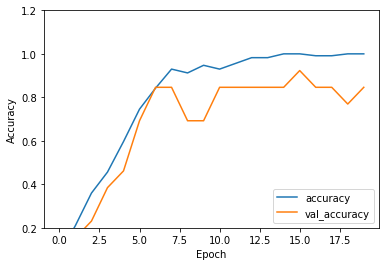

In [81]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate([cnn_test_X, rnn_test_X], rnn_test_y, verbose=2)

In [86]:
NUM_OF_PREDICTIONS = 10

for i in range(NUM_OF_PREDICTIONS):
    model_prediction = model.predict([[cnn_test_X[-i-1], rnn_test_X[-i-1]]])
    prediction = np.argmax(model_prediction)

    print(f"The prediction of the drawing is: {LABELS[prediction][1]}")
    print(f"The actual label is: {LABELS[rnn_test_y[-i-1]][1]} - It's number is: {rnn_test_y[-i-1]}")
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 2)
    plt.xticks([i for i in range(len(LABELS))])
    plt.bar(range(len(LABELS)), model_prediction[0][0:len(LABELS)], color="#777777")
    plt.ylim(0.0, 1.0)
    
    plt.show()

ValueError: could not broadcast input array from shape (64,64,1) into shape (64,64)